In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import figure, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from scipy.optimize import curve_fit

plt.rc("xtick", labelsize=10, top=True,direction="in") #Fontstørrelse på akser, ticks indad
plt.rc("ytick", labelsize=10, right=True, direction="in") #Samme som ovenstående men for y
plt.rc("axes", grid=True, linewidth=1.3) #Slår grid til, og sætter tykkelsen af plot-spine
plt.rc("grid", ls=":", lw=1) #Sætter gridstyle som ":"
plt.rc('font', size=10) #Font og fontstørrelse
plt.rc("figure", figsize=(10,3), dpi=150) #Figurstørrelse og opløsningen på graferne
plt.rc("ytick.major", width=1.3) #Sætter tykkelsen på yticks
plt.rc("xtick.major", width=1.3) #Sætter tykkelsen på xticks

In [3]:
#### paths ####  # Zn 0.37 resten cobber. 
# TODO: 1 kør med korrekt combination af mseeing 
# 2 kør med deres energi og se om de samme nuclei skabes som dem
# 3 fix sobp.dat fil og prøv at kør den treatmentplan uden collimator og med collimator 

absolute_path = os.path.abspath('').rstrip("/python_notebook")
brass20_1p25_paths = glob.glob(absolute_path + "/Full_Sim/20brass1p25mm/20brass1p25*sum.lis")
brass20_1p25_paths.sort()

# all these are dz = 50 mm 
brass1p0_paths = glob.glob(absolute_path + "/Full_Sim/50brass1p0mm/50brass1p0*sum.lis")
brass1p0_paths.sort()
brass1p27_paths = glob.glob(absolute_path + "/Full_Sim/50brass1p27mm/50brass1p27*sum.lis")
brass1p27_paths.sort()
brass1p5_paths = glob.glob(absolute_path + "/Full_Sim/50brass1p5mm/50brass1p5*sum.lis")
brass1p5_paths.sort()

tungsten1p0_paths = glob.glob(absolute_path + "/Full_Sim/20tungsten1p0mm/20tungsten1p0*sum.lis")
tungsten1p0_paths.sort()
tungsten1p27_paths = glob.glob(absolute_path + "/Full_Sim/20tungsten1p27mm/20tungsten1p27*sum.lis")
tungsten1p27_paths.sort()
tungsten1p5_paths = glob.glob(absolute_path + "/Full_Sim/20tungsten1p5mm/20tungsten1p5*sum.lis")
tungsten1p5_paths.sort()

sobp_path = absolute_path + "/sobp_format.dat"

test_script = glob.glob(absolute_path + "/reliability/recreation_*_sum.lis")
test_script.sort()

In [4]:
columns = ["E", "dE", "X", "Y", "FWHMx", "FWHMy", 1, 2, 3, 4, "W"]
sobp_data = pd.DataFrame(np.loadtxt(sobp_path, skiprows=2), columns=columns)
sobp_data = sobp_data.drop(columns=[1,2,3,4])

In [5]:
fmt = '%1.5f', '%1.5f', '%1.5f', '%1.5f', '%1.5f', '%1.5f', '%.8e'
#np.savetxt(absolute_path + "/correct_treatmentplan/sobp.dat", sobp_data.values, delimiter=', ', fmt=fmt)

In [6]:
cool_times_dict = {
    "cool1": 300, "cool2": 900, "cool3": 3600, "cool4": 7200, "cool5": 14400, "cool6": 28800, "cool7": 57600,
    "cool8": 86400, "cool9": 115200, "cool10": 259200, "cool11": 450, "cool12": 1400, "cool13": 2500, 
    "cool14": 5400, "cool15": 10800, "cool16": 360000, "cool17": 21600, "cool18": 43200, "cool19": 150,
    "cool20": 600, "cool30": 0
}

In [15]:
def get_df_tab(path: str) -> [pd.DataFrame, pd.DataFrame]:
    df = pd.read_csv(path)
    cool_time = cool_times_dict[df.iloc[0, 0].replace(" ", "")]
    vals = df.loc[df[df.columns[0]].str.contains("#")].index.values
    df_isotopes = df.iloc[vals[0]+1:vals[1], 0].str.split(expand = True).astype(float)
    df_isomer = df.iloc[vals[1]+1:, 0].str.split(expand = True).astype(float)
    df_isotopes.columns = ["A", "Z", "Bq", "dBq"]
    df_isotopes.columns.name = cool_time
    df_isomer.columns = ["A", "Z", "m", "Bq", "dBq"]
    df_isomer.columns.name = cool_time
    return df_isotopes, df_isomer

def get_df_sum(path: str, extra = False, number = 3) -> [pd.DataFrame, pd.DataFrame]:
    skipper = 18
    if extra:
        skipper = 194
    df = pd.read_csv(path, skiprows=skipper)
    vals = df.loc[df[df.columns[0]].str.contains("A")].index.values
    for i in range(len(vals)-1):
        if vals[i+1]-vals[i] <= 1:
            continue
        columns = df.iloc[vals[i], 0].split()[3:]
        dff = df.iloc[vals[i]+1:vals[i+1], 0].str.split(expand = True).reset_index().drop("index", axis=1)
        try:
            ff = dff.loc[::2,:len(columns)].set_index(0).astype(float)
        except ValueError:
            dff = dff.drop(dff.tail(1).index)
            ff = dff.loc[::2,:len(columns)].set_index(0).astype(float)
        ff.columns = columns
        dd = df.iloc[vals[i]+1:vals[i+1], 0]
        dd = dd.str.replace("+", "", regex=True)
        dd = dd.str.replace("/", "", regex=True)
        dd = dd.str.replace("-", "", regex=True)
        dd = dd.str.replace("%", "", regex=True)
        dd = dd.str.split(expand = True).reset_index().drop("index", axis=1)
        dg = dd.loc[1::2,:len(columns)-1].astype(float)
        dg.columns = columns
        dg.index = ff.index
        if i == 0:
            tot_df = ff
            tot_df_d = dg
        else:
            tot_df = pd.concat([tot_df, ff])
            tot_df_d = pd.concat([tot_df_d, dg])
    name = cool_times_dict[f"cool{int(path.split('_')[number])-20}"]
    tot_df_d.columns.name = name
    tot_df.columns.name = name
    return tot_df, tot_df_d
    
        
    
def plot_img(df: pd.DataFrame, pivot: bool, transpose = False) -> None:
    plt.figure(figsize=(7, 5))
    plt.title(f"Cooling time in sec = {df.columns.name}")
    ax = plt.gca()
    if pivot:
        data = df.pivot_table(index='Z', columns='A', values='Bq')
    else:
        df.index = df.index.astype(int)
        df = df.sort_index()
        last_value = df.index[-1]
        df = df.transpose()
        df.index = df.index.astype(int)
        df = df.sort_index()
        last_value2 = df.index[-1]
        aa = pd.DataFrame(index=range(last_value+1), columns =range(last_value2+1))
        aa.iloc[df.columns.values, df.index.values] = df.transpose().values
        data = aa.fillna(0)
    if transpose:
        data = data.transpose()
    im = ax.imshow(data, cmap=cm.gnuplot, norm=LogNorm(vmin=0.1, vmax=10000), origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.xlabel("A")
    plt.ylabel("Z")
    plt.colorbar(im, cax=cax)
    plt.show()
    return 


def find_elements(df: pd.DataFrame, threshold: float, cool_in_sec=False) -> pd.DataFrame:
    A = np.array([])
    Z = np.array([])
    value = np.array([])
    for i in df.columns:
        temp_df = df.loc[df[i] > threshold, i]
        A = np.concatenate((A, temp_df.index.values), axis=None)
        Z = np.concatenate((Z, int(i)*np.ones(len(temp_df.values))), axis=None)
        value = np.concatenate((value, temp_df.values), axis=None)
    
    df_return = pd.DataFrame(A, columns=["A"])
    df_return["Z"] = Z.astype(int)
    df_return["Bq"] = value
    print("Cooling time =", df.columns.name if cool_in_sec else df.columns.name/60/60,
          "Seconds" if cool_in_sec else "Hours",
          f"| Threshold = {threshold:.0f}")
    return df_return.sort_values("Bq", ascending=False)


def sort_df(df: pd.DataFrame) -> pd.DataFrame:
    A = np.array([])
    Z = np.array([])
    value = np.array([])
    for i in df.columns:
        temp_df = df.loc[:,i]
        A = np.concatenate((A, temp_df.index.values), axis=None)
        Z = np.concatenate((Z, int(i)*np.ones(len(temp_df.values))), axis=None)
        value = np.concatenate((value, temp_df.values), axis=None)
    
    df_return = pd.DataFrame(A, columns=["A"])
    df_return["Z"] = Z.astype(int)
    df_return["Bq"] = value
    return df_return.fillna(0)


def indv_atom(type_: str, A: str, Z: str, number=3) -> list:
    paths = type_
    
    values = []
    for i in paths:
        try:
            ff1, uncb = get_df_sum(i, number=number)
            values.append(ff1.loc[A, Z].sum())
        except Exception as e:
            print("error : ", e)
            values.append(0)
    return values


def plot_spec(type_: str, A: list, Z: list, number=3, ylog=False) -> None:
    paths = type_
    times = []
    
    for path in paths:
        times.append(cool_times_dict[f"cool{int(path.split('_')[number])-20}"])
        
    data = pd.DataFrame(index=times)
    for a, z in zip(A, Z):
        data[f"{a}, {z}"] = indv_atom(type_, a, z, number=number)
    data = data.sort_index()
    for i in data.columns:
        plt.plot(data.index.values/60/60, data[i].values, label=i)
    plt.xlabel("Hours")
    plt.ylabel("Bq")
    if ylog:
        plt.yscale("log")
    plt.legend()
    plt.show()
    
    return
    

def get_df_from_data(path: str, one_dim=False) -> pd.DataFrame:
    values = np.loadtxt(path)
    columns = ["z", "value", "error"] if one_dim else ["x", "y", "value", "error"]
    df = pd.DataFrame(data=values, columns=columns)
    return df
    
    
def plot_datfile(path, onedim=False) -> None:
    df = get_df_from_data(path, onedim)
    if onedim:
        plt.errorbar(df["z"].values, df["value"].values, yerr=df["error"].values, fmt="o", markersize=4
                     , capsize=5)
        plt.show()
    else:
        data = df.pivot_table(index='x', columns='y', values='value')
        fig, ax = plt.subplots(figsize=(20, 4))
        im = ax.imshow(data, cmap=cm.gnuplot, norm=LogNorm(vmin=data.min().min(), vmax=data.max().max())
                       , origin='lower')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.xlabel("A")
        plt.ylabel("Z")
        plt.colorbar(im, cax=cax)
        plt.show()

        
def get_val_unc(paths, number=3):
    times = []
    sums = []
    uncs = []

    for path in paths:
        try:
            df, unc = get_df_sum(path)
            sums.append(df.sum().sum())
            times.append(cool_times_dict[f"cool{int(path.split('_')[number])-20}"])
            df_unc = (df*unc/100)**2
            uncs.append((df_unc.sum().sum())**(1/2))
        except:
            print(path)
    
    return times, sums, uncs

def get_tot_df(paths: list, number=3):
    tungsten_paths = paths
    tot_df_tungsten, extra = get_df_sum(tungsten_paths[0], number=number)
    tot_df_tungsten = sort_df(tot_df_tungsten)

    for i in range(1, len(tungsten_paths)):
        path = tungsten_paths[i]
        df, extra = get_df_sum(path, number=number)
        tot_df_tungsten = pd.concat([tot_df_tungsten, sort_df(df)], join="inner")

    df_sums_tungsten = pd.pivot_table(tot_df_tungsten, index=["A", "Z"], values=["Bq"], aggfunc=np.sum)
    df_sums_tungsten = df_sums_tungsten.sort_values(by="Bq", ascending=False)
    return df_sums_tungsten


def funlin(x, a, gamma, b):
    return a*np.exp(-gamma*x) + b # no offset 


def fit_data(df, df_uncs, guess=[7e8, 0.00009, 2e8], prints = False):

    xlin = np.array([300, 900, 3600, 7200,
 14400,
 28800,
 57600,
 86400,
 115200,
 259200,
 450,
 1400,
 2500,
 5400,
 10800,
 360000,
 21600,
 43200,
 150,
 600])

    ylin = df

    yler = df_uncs

    popt, pcov = curve_fit(funlin, xlin, ylin, p0=guess, sigma=yler, absolute_sigma=True)

    perr = np.sqrt(np.diag(pcov))
    if prints:
        print('a:',popt[0],'    gamma :',popt[1], "c : ",popt[2])
        print('usikkerheder:',perr)
        print("halflife = ", 1/popt[1]/60/60, " hours +-", (1/popt[1]**4*perr[1]**2)**(1/2)/60/60)
        
    return popt, perr

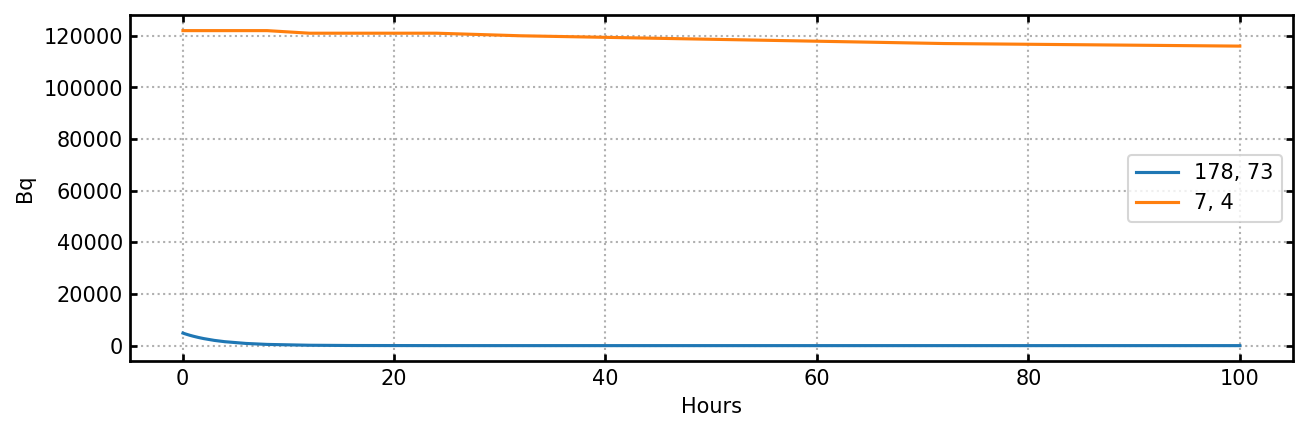

In [20]:
plot_spec(tungsten1p27_paths, ["178", "7"], ["73", "4"], ylog=False)

#### Halflife:  (181, 74) = 121.2 days | (178, 74) = 21.6 days | (177, 73) = 56.56 hours


In [87]:
df_tester = get_tot_df(test_script, number=2)
df_tester[df_tester.values > df_tester.max()[0]/10]

In [108]:
test1, ff2 = get_df_sum(test_script[18], number=2)
find_elements(test1, test1.max().mean()*5, cool_in_sec=True)

Cooling time = 150 Seconds | Threshold = 5293


,A,Z,Bq
3,62,29,46100.0
2,64,29,37700.0
4,61,29,23500.0
6,63,30,13700.0
0,58,27,13600.0
5,65,30,7630.0
1,57,27,6510.0


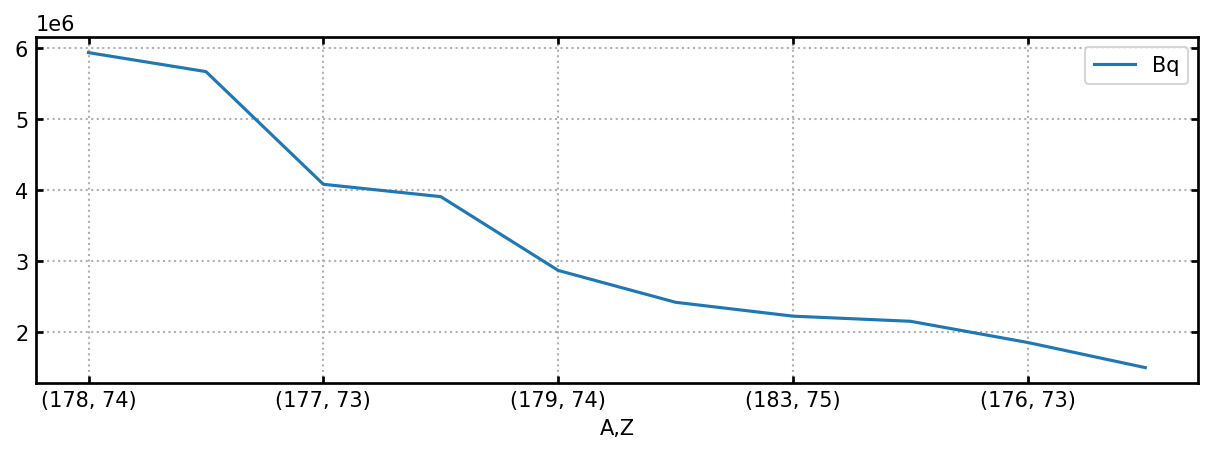

,,Bq
A,Z,
178,74,5.938000e+06
181,74,5.671000e+06
177,73,4.084900e+06
181,75,3.911090e+06
179,74,2.872512e+06
7,4,2.424000e+06
183,75,2.229000e+06
177,74,2.156855e+06
176,73,1.857925e+06


In [9]:
df_sums_tungsten_27 = get_tot_df(tungsten1p27_paths)
df_sums_tungsten_27[:10].plot()
plt.show()
df_sums_tungsten_27[:10]

#### Halflife:  (64, 29) = 12.7 hours | (62, 29) = 9.67 min | (58, 27) = 70.86 days | (7, 4) = 53.22 d


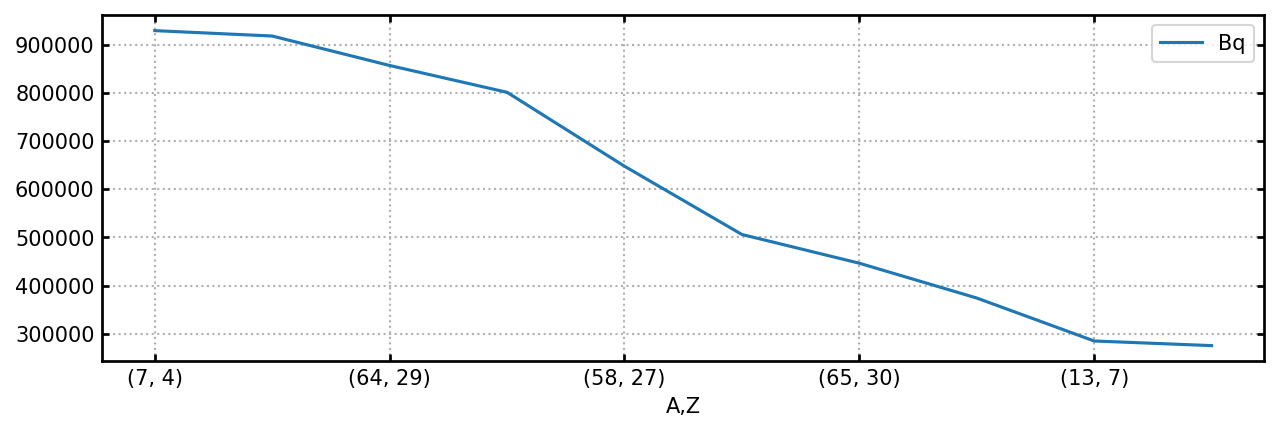

,,Bq
A,Z,
7,4,929300.000000
61,29,918089.028485
64,29,856949.000000
62,29,801284.300000
58,27,647900.000000
11,6,506153.717572
65,30,446500.000000
63,30,374245.042860
13,7,285058.023911


In [10]:
df_sums_brass_27 = get_tot_df(brass1p27_paths)
df_sums_brass_27[:10].plot()
plt.show()
df_sums_brass_27[:10]

In [11]:
ff1, ff2 = get_df_sum(brass1p27_paths[15])
find_elements(ff1, ff1.max().mean()*10)

Cooling time = 100.0 Hours | Threshold = 16341


,A,Z,Bq
2,7,4,44400.0
0,58,27,31300.0
1,65,30,22100.0


In [12]:
ff1, ff2 = get_df_sum(tungsten1p27_paths[15])
find_elements(ff1, ff1.max().mean()*10)

Cooling time = 100.0 Hours | Threshold = 81718


,A,Z,Bq
0,181,74,279000.0
1,178,74,265000.0
3,7,4,116000.0
2,183,75,108000.0


In [31]:
ff1, ff2 = get_df_sum(brass1p27_paths[8])
find_elements(ff1, ff1.max().mean(), True)

Cooling time = 115200 Seconds | Threshold = 1989


,A,Z,Bq
11,7,4,46000.0
5,58,27,32200.0
9,65,30,22300.0
6,57,27,13300.0
8,64,29,10600.0
2,203,82,9610.0
0,201,81,7180.0
7,56,27,7170.0
10,67,31,6980.0
4,205,83,6780.0


In [28]:
ff1, ff2 = get_df_sum(tungsten1p27_paths[18])
ff1 = find_elements(ff1, ff1.max().mean(), True)
len(ff1), ff1

Cooling time = 150 Seconds | Threshold = 20317


(27,
       A   Z        Bq
 8   179  74  389000.0
 9   178  74  302000.0
 7   181  74  284000.0
 24   11   6  259000.0
 16  181  75  257000.0
 18  179  75  242000.0
 2   177  73  229000.0
 10  177  74  220000.0
 25   13   7  195000.0
 19  178  75  163000.0
 20  177  75  138000.0
 3   176  73  130000.0
 17  180  75  124000.0
 11  176  74  122000.0
 23    7   4  122000.0
 14  183  75  112000.0
 6   185  74   75600.0
 4   175  73   67300.0
 1   179  73   66800.0
 26   15   8   66000.0
 13  184  75   59800.0
 12  175  74   56600.0
 0   175  72   56000.0
 21  176  75   55300.0
 15  182  75   54200.0
 22  175  75   29400.0
 5   174  73   24100.0)

In [25]:
ff

,A,Z,Bq
45,179,74,3.890000e+05
46,178,74,3.020000e+05
44,181,74,2.840000e+05
182,11,6,2.590000e+05
59,181,75,2.570000e+05
...,...,...,...
103,98,41,2.210000e-15
180,15,6,1.490000e-17
170,33,17,7.070000e-18
101,100,41,5.360000e-30


In [15]:
tungsten_t, tungsten_sums_27, unc_tungsten_sums_27 = get_val_unc(tungsten1p27_paths)
tungsten_t1, tungsten_sums_0, unc_tungsten_sums_0 = get_val_unc(tungsten1p0_paths)
tungsten_t2, tungsten_sums_5, unc_tungsten_sums_5 = get_val_unc(tungsten1p5_paths)

times_brass_27, sums_brass_27, unc_sums_brass_27 = get_val_unc(brass1p27_paths)
times_brass20_25, sums_brass20_25, unc_sums_brass20_25 = get_val_unc(brass20_1p25_paths)
times_brass_0, sums_brass_0, unc_sums_brass_0 = get_val_unc(brass1p0_paths)
times_brass_5, sums_brass_5, unc_sums_brass_5 = get_val_unc(brass1p5_paths)

In [32]:
unc_sums_brass20_25

[3939.1713731444406,
 3062.915183937062,
 2442.3859038655783,
 2322.803978225278,
 2194.3395106795588,
 2021.1519086663482,
 1835.4300491292381,
 1751.2083742319585,
 1704.6281785493582,
 1591.3192357284531,
 3635.509704376171,
 2756.060741129758,
 2535.3789734232955,
 2371.9613469756987,
 2248.043116427192,
 1547.656934522333,
 2096.1784612429506,
 1908.1665310153026,
 4348.588455482173,
 3396.887169028473]

In [16]:
popt_tungsten_27, perr_tungsten_27 = fit_data(tungsten_sums_27, unc_tungsten_sums_27, prints=True)
popt_tungsten_0, perr_tungsten_0 = fit_data(tungsten_sums_0, unc_tungsten_sums_0, prints=True)
popt_tungsten_5, perr_tungsten_5 = fit_data(tungsten_sums_5, unc_tungsten_sums_5, prints=True)

popt_brass_27, perr_brass_27 = fit_data(sums_brass_27, unc_sums_brass_27, prints=True)
popt_brass20_25, perr_brass20_25 = fit_data(sums_brass20_25, unc_sums_brass20_25, prints=True)
popt_brass_0, perr_brass_0 = fit_data(sums_brass_0, unc_sums_brass_0, prints=True)
popt_brass_5, perr_brass_5 = fit_data(sums_brass_5, unc_sums_brass_5, prints=True)

a: 2183317.9401942766     gamma : 0.00015386893665595927 c :  1451346.115639064
usikkerheder: [2.39279518e+03 4.43312766e-07 1.04100445e+03]
halflife =  1.8052882135584682  hours +- 0.005201227278503922
a: 2261613.297498183     gamma : 0.00020395669129625972 c :  1402939.4378837575
usikkerheder: [2.86102108e+03 6.23536655e-07 1.06147192e+03]
halflife =  1.3619449110119577  hours +- 0.004163739704020305
a: 2167178.756807656     gamma : 0.00012726917631294038 c :  1502677.040942385
usikkerheder: [2.15197072e+03 3.42926250e-07 1.01390650e+03]
halflife =  2.182600577965194  hours +- 0.005881007906706839
a: 513698.7440713694     gamma : 0.00015001050167631798 c :  211141.99402230015
usikkerheder: [5.14947680e+02 3.83511741e-07 2.04435830e+02]
halflife =  1.8517222106032747  hours +- 0.004734049952796169
a: 1210211.9728868778     gamma : 0.00018019596695504516 c :  500211.5552930267
usikkerheder: [1.81934460e+03 6.36718798e-07 6.35275977e+02]
halflife =  1.5415316029080555  hours +- 0.005446

In [17]:
def add_plot(xs, ys, uncs, popt, perr, label, type_ = "o"):
    plt.plot(xs/60/60, funlin(xs, *popt), "--", color="black")
    plt.errorbar(np.array(tungsten_t)/60/60, ys, yerr=uncs, fmt=type_, markersize=4,
                 capsize=5, label=label)

    plt.fill_between(xs/60/60, funlin(xs, popt[0]-perr[0], popt[1]+perr[1], popt[2]-perr[2]),
                     funlin(xs, popt[0]+perr[0], popt[1]-perr[1], popt[2]+perr[2]), color="lightgrey")
    return

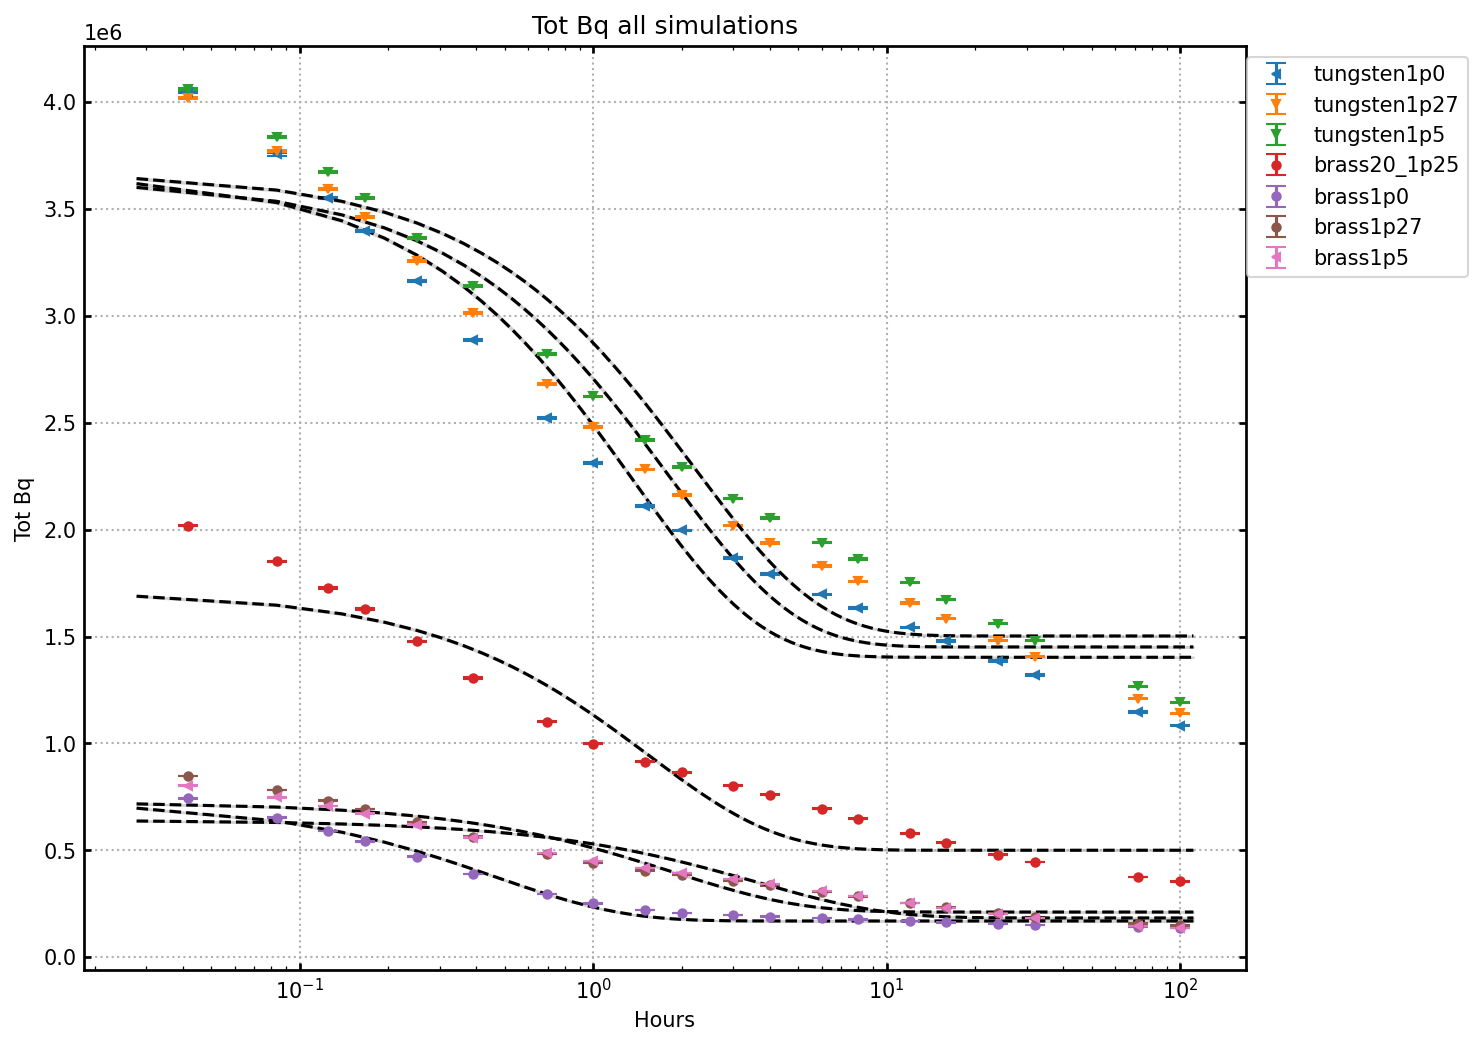

In [22]:
xs = np.linspace(100, 4e5, 2000)
plt.rc("figure", figsize=(10,8), dpi=150)

add_plot(xs, tungsten_sums_0, unc_tungsten_sums_0, popt_tungsten_0, perr_tungsten_0, "tungsten1p0", '<') 
add_plot(xs, tungsten_sums_27, unc_tungsten_sums_27, popt_tungsten_27, perr_tungsten_27, "tungsten1p27", 'v') 
add_plot(xs, tungsten_sums_5, unc_tungsten_sums_5, popt_tungsten_5, perr_tungsten_5, "tungsten1p5", 'v') 
add_plot(xs, sums_brass20_25, unc_sums_brass20_25, popt_brass20_25, perr_brass20_25, "brass20_1p25") 
add_plot(xs, sums_brass_0, unc_sums_brass_0, popt_brass_0, perr_brass_0, "brass1p0")
add_plot(xs, sums_brass_27, unc_sums_brass_27, popt_brass_27, perr_brass_27, "brass1p27") 
add_plot(xs, sums_brass_5, unc_sums_brass_5, popt_brass_5, perr_brass_5, "brass1p5", '<') 


plt.title("Tot Bq all simulations")
plt.xlabel("Hours")
plt.ylabel("Tot Bq")
#plt.yscale("log")
plt.xscale("log")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
plt.show()

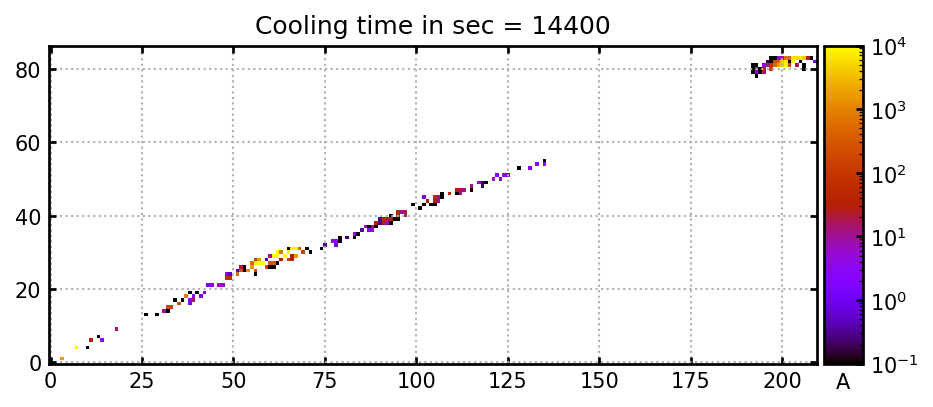

In [55]:
ff1, ff2 = get_df_sum(brass1p27_paths[4])
plot_img(ff1, False, True)

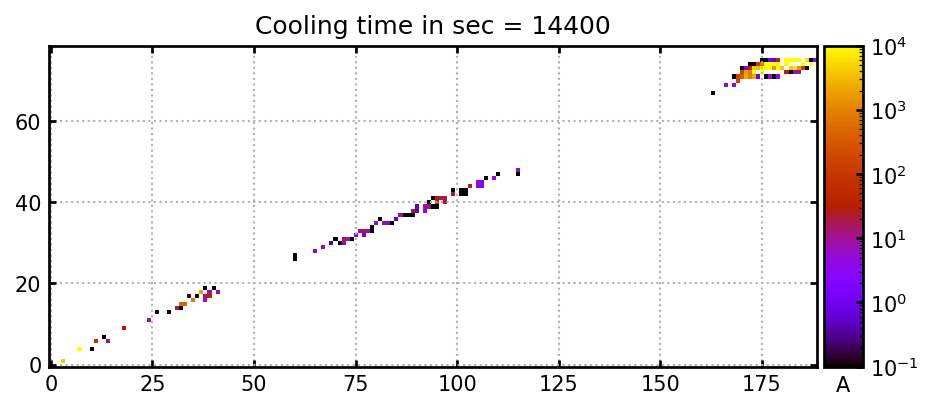

In [56]:
ff1, ff2 = get_df_sum(tungsten1p27_paths[4])
plot_img(ff1, False, True)